# Plot Perturbed

This notebook organizes the plotting of the results of the perturbation experiments. Run the following cells to import the required packages and load some helper functions.

In [2]:
# Reload modules before executing code
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from retrieval_exploration.common import util

# Use the same palette for all plots & figures in the paper.
FONT_SIZE = 14
sns.set(font_scale=2)
sns.set_theme(style="ticks")
sns.set_palette("deep")

# Display all columns in DataFrame.
pd.set_option("display.max_columns", None)

/Users/johngiorgi/Library/Caches/pypoetry/virtualenvs/retrieval-exploration-C-nHY9Y1-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Point the variable `data_dir` to the location of a directory that contains the results of running one of the `run_*.py` scripts.

In [18]:
data_dir = "../output/results/multinews"
!ls $data_dir

pegasus primera


Then run the following lines to load the data and perform any post-processing

In [24]:
baseline_df, perturbed_df = util.load_results_dicts(
    data_dir,
    metric_columns=[
        "predict_rouge_avg_fmeasure",
        "predict_bertscore_f1",
    ],
)

100%|██████████| 48/48 [01:45<00:00,  2.20s/it]


In [25]:
# Replace model names with something more readable
perturbed_df = perturbed_df.replace(
    {
        "google/pegasus-multi_news": "PEGASUS",
        "allenai/PRIMERA-multinews": "PRIMERA",
        "allenai/PRIMERA-multixscience": "PRIMERA",
    },
)

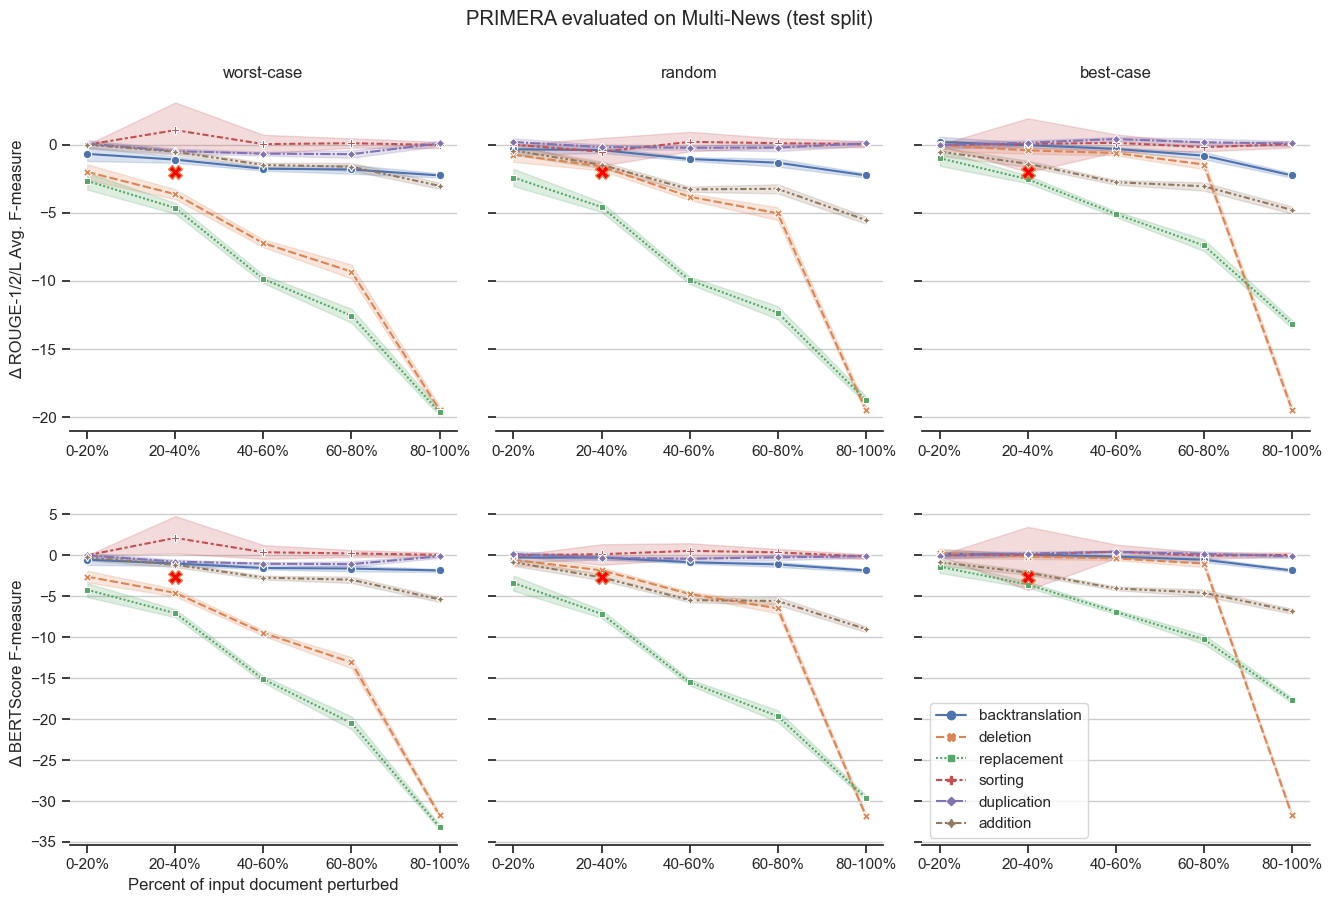

In [33]:
# Set up the figure axes
fig, axes = plt.subplots(figsize=(16, 9.6), nrows=2, ncols=3, sharey="row")
plt.subplots_adjust(top=0.90, wspace=0.1)

# Don't include sorting or duplication, as they have a jaccard similarity of 1.0, always.
# df = perturbed_df[(perturbed_df.predict_perturbation != "sorting") & (perturbed_df.predict_perturbation != "duplication")]
df = perturbed_df.copy()
df = df[df.predict_model_name_or_path == "PRIMERA"]

# Bin the data into equal-sized bins
# labels=["0.25-0", "0.50-0.25", "0.75-0.50", "1.0-0.75"]
# labels=["0.20-0", "0.40-0.20", "0.60-0.40", "0.80-0.60", "1.0-0.80"]
# df.jaccard_similarity_scores = pd.cut(df.jaccard_similarity_scores, 3, labels=["0.25-0", "0.50-0.25", "0.75-0.50"])
# df.jaccard_similarity_scores = pd.cut(df.jaccard_similarity_scores, 5, labels=["0.20-0", "0.40-0.20", "0.60-0.40", "0.80-0.60", "1.0-0.80"])
df.frac_docs_perturbed = pd.cut(df.frac_docs_perturbed, 5, labels=["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])


for i, metric in enumerate(["predict_rouge_avg_fmeasure_delta", "predict_bertscore_f1_delta"]):
    for j, strategy in enumerate(["worst-case", "random", "best-case"]):

        g = sns.lineplot(
            data=df[df.predict_selection_strategy == strategy],
            x="frac_docs_perturbed",
            y=metric,
            hue="predict_perturbation",
            style="predict_perturbation",
            estimator="mean",
            ci=95,
            n_boot=1000,
            markers=True,
            ax=axes[i][j],
        )
        g.set_xlabel("")
        g.set_ylabel("")
        g.set_title("")

        if metric == "predict_rouge_avg_fmeasure":
            if j == 0:
                import matplotlib.patheffects as PathEffects
                txt = g.text("0-20%", -1.60, s="Sparse (-1.60)", fontdict={"color": "#FF3D00", "weight": "bold"})
                txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
                # g.plot("20-40%", -2.01)
            # g.axhline(-1.60, color="#FF3D00", linestyle="dotted")
        # if metric == "predict_bertscore_f1_delta":
        #     if j == 0:
        #         txt = g.text("0-20%", -2.66, s="Sparse (-2.66)", fontdict={"color": "#FF3D00", "weight": "bold"})
        #         txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        #     g.axhline(-2.66, color="#FF3D00", linestyle="dotted")


axes[-1][0].set_xlabel("Percent of input document perturbed")
axes[0][0].set_ylabel("Δ ROUGE-1/2/L Avg. F-measure")
axes[1][0].set_ylabel("Δ BERTScore F-measure")

axes[0][0].set_title("worst-case")
axes[0][1].set_title("random")
axes[0][2].set_title("best-case")

# Remove duplicate legends
for ax in axes.flatten()[:-1]:
    ax.legend_ = None

# Additional per-axis styling
for ax in axes.flatten():
    # Invert the order of the x-axis
    # ax.invert_xaxis()
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)
# Rotates X-Axis Ticks by 45-degrees
# plt.xticks(rotation=45)

for i in range(len(axes[0])):
    axes[0][i].plot("20-40%", -2.01, marker="X", markersize=10, markerfacecolor="red")
    axes[1][i].plot("20-40%", -2.66, marker="X", markersize=10, markerfacecolor="red")
axes[-1][-1].legend(loc="lower left")

plt.suptitle("PRIMERA evaluated on Multi-News (test split)")
plt.savefig("../output/plots/PRIMERA.png", dpi=300, facecolor="white")

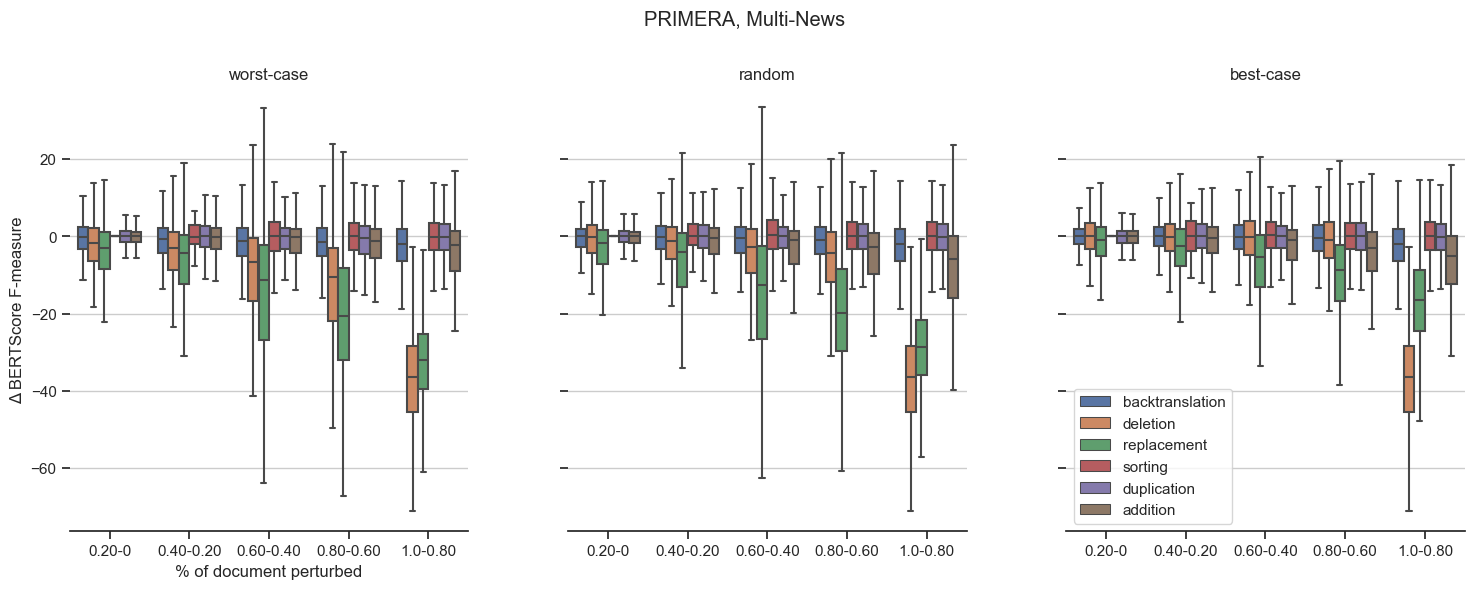

In [111]:
# Set up the figure axes
fig, axes = plt.subplots(figsize=(18, 6), ncols=3, sharey=True)
plt.subplots_adjust(top=0.85, wspace=0.25)

# Don't include sorting or duplication, as they have a jaccard similarity of 1.0, always.
# df = perturbed_df[(perturbed_df.predict_perturbation != "sorting") & (perturbed_df.predict_perturbation != "duplication")]
df = perturbed_df.copy()

# Bin the data into equal-sized bins
# labels=["0.25-0", "0.50-0.25", "0.75-0.50", "1.0-0.75"]
# labels=["0.20-0", "0.40-0.20", "0.60-0.40", "0.80-0.60", "1.0-0.80"]
# df.jaccard_similarity_scores = pd.cut(df.jaccard_similarity_scores, 3, labels=["0.25-0", "0.50-0.25", "0.75-0.50"])
# df.jaccard_similarity_scores = pd.cut(df.jaccard_similarity_scores, 5, labels=["0.20-0", "0.40-0.20", "0.60-0.40", "0.80-0.60", "1.0-0.80"])
df.frac_docs_perturbed = pd.cut(df.frac_docs_perturbed, 5, labels=["0.20-0", "0.40-0.20", "0.60-0.40", "0.80-0.60", "1.0-0.80"])

g = sns.boxplot(
    data=df[df.predict_selection_strategy == "worst-case"],
    x="frac_docs_perturbed",
    y="predict_bertscore_f1_delta",
    hue="predict_perturbation",
    showfliers=False,
    ax=axes[0],
)
g.set_xlabel("% of document perturbed")
g.set_ylabel("Δ BERTScore F-measure")
g.set_title("worst-case")

g = sns.boxplot(
    data=df[df.predict_selection_strategy == "random"],
    x="frac_docs_perturbed",
    y="predict_bertscore_f1_delta",
    hue="predict_perturbation",
    showfliers=False,
    ax=axes[1],
)
g.set_xlabel("")
g.set_ylabel("")
g.set_title("random")

g = sns.boxplot(
    data=df[df.predict_selection_strategy == "best-case"],
    x="frac_docs_perturbed",
    y="predict_bertscore_f1_delta",
    hue="predict_perturbation",
    showfliers=False,
    ax=axes[2],
)
g.set_xlabel("")
g.set_ylabel("")
g.set_title("best-case")

# Remove duplicate legends
for ax in axes.flatten()[:-1]:
    ax.legend_ = None

# Additional per-axis styling
for ax in axes.flatten():
    # Invert the order of the x-axis
    # ax.invert_xaxis()
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)
axes[2].legend(loc="lower left")

plt.suptitle("PRIMERA, Multi-News")
plt.savefig("../output/plots/pegasus-multi-news.png", dpi=300, facecolor="white")

In [ ]:
import random

# Collect all examples in the "uptick" region
uptick_df = perturbed_df[
    (perturbed_df["jaccard_similarity_scores"] <= 0.2) & (perturbed_df["predict_perturbation"] == "addition")
]

# Filter by examples that saw a positive delta
uptick_pos_delta_df = uptick_df[uptick_df["predict_bertscore_f1_delta"] < 0]


baseline_filtered_df = baseline_df[baseline_df["predict_example_idx"].isin(uptick_pos_delta_df["predict_example_idx"])]


(baseline_filtered_df.predict_label_len - baseline_filtered_df.predict_gen_len).describe()
(uptick_pos_delta_df.predict_label_len - uptick_pos_delta_df.predict_gen_len).describe()


# predict_example_idx = uptick_df.iloc[idx].predict_example_idx
# predict_inputs = uptick_df.iloc[idx].predict_inputs
# predict_outputs = uptick_df.iloc[idx].predict_preds
# target = uptick_df.iloc[idx].predict_labels

# filtered_baseline_df = baseline_df[baseline_df["predict_example_idx"] == predict_example_idx]
# baseline_inputs = filtered_baseline_df.predict_inputs
# baseline_outputs = filtered_baseline_df.predict_preds

print(
    f"{len(uptick_pos_delta_df)}/{len(uptick_df)} ({len(uptick_pos_delta_df)/len(uptick_df):.2%}) examples in this range have positive deltas"
)
print()
print(
    f"- Mean input length of dataset: {int(baseline_df.predict_input_len.mean())} +/- {int(baseline_df.predict_input_len.std())}"
)
print(
    f"- Mean input length of examples with positive deltas in uptick region (pre-perturbation): {int(baseline_filtered_df.predict_input_len.mean())} +/- {int(baseline_filtered_df.predict_input_len.std())}"
)
print("Insight: examples in uptick region have much shorter inputs than the datasets average.")
print()
print(
    f"- Mean baseline performance: {int(baseline_df.predict_bertscore_f1_mean[0])} +/- {int(baseline_df.predict_bertscore_f1.std())}"
)
print(
    f"- Mean performance of examples in uptick region (pre-perturbation): {int(baseline_filtered_df.predict_bertscore_f1.mean())} +/- {int(baseline_filtered_df.predict_bertscore_f1.std())}"
)
print("Insight: examples in uptick region have very low scores even pre-perturbation.")
print()
print(f"Random example: '{baseline_filtered_df.sample().predict_inputs.item()}'")

In [ ]:
baseline_df.predict_bertscore_f1_mean[0].item(), baseline_filtered_df.predict_bertscore_f1.mean()

In [ ]:
baseline_df[baseline_df["predict_example_idx"].isin(uptick_pos_delta_df["predict_example_idx"])][
    "predict_input_len"
].describe()

In [ ]:
target

In [ ]:
baseline_inputs.item()

In [ ]:
baseline_outputs.item()

In [ ]:
predict_inputs

In [ ]:
predict_outputs

In [ ]:
tmp = perturbed_df
tmp = tmp[tmp.predict_perturbed_frac == 1.0]
tmp[tmp.jaccard_similarity_scores > 0.8].predict_perturbation.value_counts()

In [ ]:
sns.violinplot(data=perturbed_df, y="jaccard_similarity_scores", x="predict_perturbed_frac")
plt.savefig("../output/plots/primera_scatter.png", dpi=300, facecolor="white")

In [ ]:
# Look at the token overlap pre- and post-perturbation for different perturbation fractions
summ_df = perturbed_df[["predict_perturbation", "predict_perturbed_frac", "predict_selection_strategy", "jaccard_similarity_scores"]]
summ_df = summ_df.groupby(["predict_perturbation", "predict_perturbed_frac", "predict_selection_strategy"], dropna=False)
summ_df = summ_df.mean().round(2)
# See https://stackoverflow.com/a/64901648/6578628 for trick to slice output of describe()
# summ_df.describe().loc[:,(slice(None),["mean", "std"])].round(1)
summ_df = summ_df.reindex(axis="index", level=0, labels=["backtranslation", "addition", "deletion", "replacement"])
summ_df.T
# sort_values("jaccard_similarity_scores")

In [ ]:
summ_df = perturbed_df[
    [
        "predict_perturbation",
        "predict_perturbed_frac",
        "predict_selection_strategy",
        "predict_rougeL_fmeasure_delta",
        "predict_bertscore_f1_delta",
    ]
]

# summ_df = summ_df[summ_df.predict_selection_strategy == "best-case"]


summ_df = summ_df.groupby(
    ["predict_perturbation", "predict_perturbed_frac", "predict_selection_strategy"], dropna=False
)
summ_df = summ_df.mean().round(2)
# See https://stackoverflow.com/a/64901648/6578628 for trick to slice output of describe()
# summ_df = summ_df.describe().loc[:,(slice(None),["mean", "std", "min", "max"])].round(2)
# Re-ordering a MultiIndex: https://stackoverflow.com/a/30010004/6578628
# "addition", "deletion", "replacement"
summ_df = summ_df.reindex(
    axis="index", level=0, labels=["sorting", "backtranslation", "duplication", "addition", "deletion", "replacement"]
).T

summ_df

- Adding dissimilar documents hurts __less__ than adding similar documents
- Backtranslation always improves performance slightly --> maybe acts as a regularizer? Forces model to do less copying?
- More perturbation doesn't necc. reduce performance. With duplication, performance actually improves.
- BARTScore has smaller __variance__ and __delta__ than other metrics
- `replacement`, `similar` is the most like the mistakes we expect a retriver to make and shows a large delta

In [ ]:
hue = "eval_model_name_or_path"

# Set up the figure axes
fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
plt.subplots_adjust(wspace=0.25)

# Draw the plots
sns.violinplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_perturbed_seed",
    y="eval_rouge_rougeL_fmeasure",
    hue=hue,
    palette="Set1",
    ax=axes[0],
)

sns.violinplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_perturbed_seed",
    y="eval_bertscore_f1",
    hue=hue,
    palette="Set1",
    ax=axes[1],
)

# Set figure and axis titles
_ = axes[0].set(
    xlabel="Seed",
    ylabel="Δ ROUGE-L F-measure",
)
_ = axes[1].set(
    xlabel="",
    ylabel="Δ BERTScore F-measure",
)

# Additional per-axis styling
for ax in axes.flatten():
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)

# Remove duplicate legends
_ = axes[0].legend_ = None

# Remove legend title
handles, labels = axes[1].get_legend_handles_labels()
_ = axes[1].legend(loc="lower right", handles=handles[:], labels=labels[:])

plt.savefig(f"../output/plots/multinews_sorting.png", dpi=400, bbox_inches="tight")

In [ ]:
# Set up the figure axes
fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
plt.subplots_adjust(wspace=0.25)

# Draw the plots
sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_num_docs",
    y="eval_rouge_rougeL_fmeasure_delta",
    hue="eval_model_name_or_path",
    palette="Set1",
    showfliers=False,
    ax=axes[0],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_num_docs",
    y="eval_bertscore_f1_delta",
    hue="eval_model_name_or_path",
    palette="Set1",
    showfliers=False,
    ax=axes[1],
    boxprops=dict(alpha=0.90),
)

# Set figure and axis titles
_ = axes[0].set(
    xlabel="Original Number of Input Documents",
    ylabel="Δ ROUGE-L F-measure",
)
_ = axes[1].set(
    xlabel="",
    ylabel="Δ BERTScore F-measure",
)

# Additional per-axis styling
for ax in axes.flatten():
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)

# Remove duplicate legends
_ = axes[0].legend_ = None

# Remove legend title
handles, labels = axes[1].get_legend_handles_labels()
_ = axes[1].legend(loc="lower right", handles=handles[:], labels=labels[:])

plt.savefig(f"../output/plots/multinews_sorting.png", dpi=400, bbox_inches="tight")

In [ ]:
import json

original_df_backtranslation = baseline_df
perturbed_df_backtranslation = perturbed_df[perturbed_df.eval_perturbation == "backtranslation"]

col = "eval_rouge_rougeL_fmeasure_delta"
idx = int(perturbed_df_backtranslation.loc[perturbed_df_backtranslation[col].idxmax()].name)

perturbed_inputs = perturbed_df_backtranslation.loc[idx].eval_inputs
original_inputs = original_df_backtranslation.loc[idx].eval_inputs

perturbed_outputs = perturbed_df_backtranslation.loc[idx].eval_preds
original_outputs = original_df_backtranslation.loc[idx].eval_preds

labels = original_df_backtranslation.loc[idx].eval_labels


with open("./best.json", "w") as f:
    json.dump(
        {
            "original_inputs": original_inputs,
            "perturbed_inputs": perturbed_inputs,
            "original_summary": original_outputs,
            "perturbed_summary": perturbed_outputs,
            "reference_summary": labels,
        },
        f,
        indent=2,
    )

In [ ]:
labels = original_df_backtranslation.eval_labels.tolist()
references = original_df_backtranslation.eval_preds.tolist()
predictions = perturbed_df_backtranslation.eval_preds.tolist()

In [ ]:
from bart_score import BARTScorer

bart_scorer = BARTScorer(device="cpu", checkpoint="facebook/bart-large-cnn")

In [ ]:
references[0], predictions[0]

In [ ]:
original_scores = bart_scorer.score(labels[:4], references[:4], batch_size=4)

In [ ]:
original_scores

In [ ]:
original_scores = bart_scorer.score(labels[:4], references[:4], batch_size=4)
perturbed_scores = bart_scorer.score(labels[:36], predictions[:36], batch_size=4)

In [ ]:
reference = """– A New York lawyer said he told Trump attorney Michael Cohen years ago that former New York Attorney General Eric Schneiderman was abusing women, reports the AP.\nSchneiderman, a frequent legal nemesis of the president, resigned this week after the New Yorker published the accounts of four women who said they were slapped and choked by the Democratic ex-prosecutor.\nAttorney Peter Gleason said in a letter filed with a federal judge Friday that he was contacted \"some years ago\" by two women who claimed Schneiderman was \"sexually inappropriate\" with them.\nGleason said he advised the women not to report what happened to prosecutors.\nInstead, he said, he discussed the matter with the retired New York Post columnist Stephen Dunleavy.\nAccording to Gleason, Dunleavy offered to talk about the issue with Trump, then not yet president.\nGleason said he then got a call from Cohen and \"shared with him certain details\" of Schneiderman's \"vile attacks\" on the women.\nIn his letter, Gleason asked US District Judge Kimba Wood to issue a protective order sealing all relevant correspondence with Cohen.\nIn a phone interview Friday, Gleason confirmed that Cohen told him during their 2013 conversation that if Trump were elected governor, he would make the allegations about Schneiderman public.\nHe added that shortly after that conversation, Trump tweeted about Schneiderman.\n\"Weiner is gone.\nSpitzer is gone - next will be lightweight A.G. Eric Schneiderman.\nIs he a crook?\nWait and see, worse than Spitzer or Weiner,\" Trump's tweet said, referring to former US Rep. Anthony Weiner and former Gov.\nEliot Spitzer, both of whom resigned because of scandals involving women."""
reference = " ".join(reference.strip().split())

predicted = """– New York Attorney General Eric Schneiderman is out after four women accused him of sexual assault, the New Yorker reports.\nTwo of the women, Michelle Manning Barish and Tanya Selvaratnam, spoke to the magazine on the condition of anonymity because they feared reprisal.\nThey say Schneiderman hit them repeatedly, often after drinking, in bed, and threatened to kill them if they broke up with him.\nA fourth woman, an attorney who has held prominent positions in the New York legal community, says Schneiderman made an advance toward her; when she rebuffed him, he slapped her across the face with such force that it left a mark that lingered the next day.\nIn a statement, Schneiderman says, \"In the privacy of intimate relationships, I have engaged in role-playing and other consensual sexual activity.\nI have not assaulted anyone.\nI have never engaged in nonconsensual sex, which is a line I would not cross.\"\nHe adds, \"While these allegations are unrelated to my professional conduct or the operations of the office, they will effectively prevent me from leading the office's work at this critical time."""
predicted = " ".join(predicted.strip().split())

np.exp(bart_scorer.score([reference], [predicted])).item()

In [ ]:
reference = """– A New York lawyer said he told Trump attorney Michael Cohen years ago that former New York Attorney General Eric Schneiderman was abusing women, reports the AP.\nSchneiderman, a frequent legal nemesis of the president, resigned this week after the New Yorker published the accounts of four women who said they were slapped and choked by the Democratic ex-prosecutor.\nAttorney Peter Gleason said in a letter filed with a federal judge Friday that he was contacted \"some years ago\" by two women who claimed Schneiderman was \"sexually inappropriate\" with them.\nGleason said he advised the women not to report what happened to prosecutors.\nInstead, he said, he discussed the matter with the retired New York Post columnist Stephen Dunleavy.\nAccording to Gleason, Dunleavy offered to talk about the issue with Trump, then not yet president.\nGleason said he then got a call from Cohen and \"shared with him certain details\" of Schneiderman's \"vile attacks\" on the women.\nIn his letter, Gleason asked US District Judge Kimba Wood to issue a protective order sealing all relevant correspondence with Cohen.\nIn a phone interview Friday, Gleason confirmed that Cohen told him during their 2013 conversation that if Trump were elected governor, he would make the allegations about Schneiderman public.\nHe added that shortly after that conversation, Trump tweeted about Schneiderman.\n\"Weiner is gone.\nSpitzer is gone - next will be lightweight A.G. Eric Schneiderman.\nIs he a crook?\nWait and see, worse than Spitzer or Weiner,\" Trump's tweet said, referring to former US Rep. Anthony Weiner and former Gov.\nEliot Spitzer, both of whom resigned because of scandals involving women."""
reference = " ".join(reference.strip().split())

predicted = """– A New York lawyer said he told Trump attorney Michael Cohen many years ago that former New York Attorney General Eric Schneiderman was abusing women, reports the AP.\nSchneiderman, a frequent legal nemesis of the president, resigned this week after the New Yorker published the accounts of four women who said they were slapped and choked by the Democratic ex-prosecutor.\nAttorney Peter Gleason said in a letter filed with a federal judge Friday that he was contacted \"some years ago\" by two women who claimed Schneiderman was \"sexually inappropriate\" with them.\nGleason said he advised the women not to report what happened to prosecutors.\nInstead, he said, he discussed the matter with the retired New York Post columnist Stephen Dunleavy.\nAccording to Gleason, Dunleavy offered to talk about the issue with Trump, then not yet president.\nGleason said he then got a call from Cohen and \"shared with him certain details\" of Schneiderman's \"vile attacks\" on the women.\nIn his letter, Gleason asked US District Judge Kimba Wood to issue a protective order sealing all relevant correspondence with Cohen.\nIn a phone interview Friday, Gleason confirmed that Cohen told him during their 2013 conversation that if Trump were elected governor, he would make the allegations about Schneiderman public.\nHe added that shortly after that conversation, Trump tweeted about Schneiderman.\n\"Weiner is gone.\nSpitzer is gone - next will be lightweight A.G. Eric Schneiderman.\nIs he a crook?\nWait and see, worse than Spitzer or Weiner,\" Trump's tweet said, referring to former US Rep. Anthony Weiner and former Gov.\nEliot Spitzer, both of whom resigned because of scandals involving women."""
predicted = " ".join(predicted.strip().split())

np.exp(bart_scorer.score([reference], [predicted])).item()

In [ ]:
((0.77 - 0.73) / 0.77) * 100

In [ ]:
np.mean((np.exp(original_scores) - np.exp(perturbed_scores)).tolist()), np.mean(
    perturbed_df_backtranslation.eval_rouge_rougeL_fmeasure_delta.tolist()[:24]
)

In [ ]:
np.std((np.exp(original_scores) - np.exp(perturbed_scores)).tolist()), np.std(
    perturbed_df_backtranslation.eval_rouge_rougeL_fmeasure_delta.tolist()[:24]
)

from datasets import load_metric
rouge = load_metric("rouge")

In [ ]:
from tqdm import tqdm

original_inputs = baseline_df.eval_inputs
perturbed_inputs = perturbed_df[perturbed_df.eval_perturbation == "backtranslation"].eval_inputs

assert len(original_inputs) == len(perturbed_inputs)

i = 0
max_count = 256
f_measure = []
for orig, pert in tqdm(zip(perturbed_inputs, original_inputs), total=max_count):
    results = rouge.compute(references=[orig], predictions=[pert], rouge_types=["rougeL"], use_stemmer=True)
    f_measure.append(results["rougeL"].mid.fmeasure)
    i += 1
    if i == max_count:
        break

In [ ]:
import numpy as np

np.mean(f_measure), np.std(f_measure)

In [ ]:
sns.histplot(f_measure)

In [ ]:
sns.regplot(
    f_measure, perturbed_df[perturbed_df.eval_perturbation == "backtranslation"].eval_rouge_rougeL_fmeasure_delta[:256]
)

In [ ]:
# df[df.epoch.notnull()] = df[df.epoch.notnull()].replace({"PRIMERA": "PRIMERA-trained"})
hue = "eval_perturbation"

# Set up the figure axes
fig, axes = plt.subplots(figsize=(16, 4), ncols=3)
# plt.subplots_adjust(hspace=0.05, wspace=0.075)

# Draw the plots
sns.boxplot(
    data=perturbed_df,
    x="eval_num_docs",
    y="eval_rouge_rougeL_fmeasure_delta",
    hue=hue,
    palette="Set1",
    # Omit outliers, otherwise this is hard to viusalize
    showfliers=False,
    ax=axes[0],
    # Pass any kwargs to matplotlib.pyplot.boxplot
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df,
    x="eval_num_docs",
    y="eval_bertscore_f1_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[1],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df,
    x="eval_num_docs",
    y="eval_bartscore_score_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[2],
    boxprops=dict(alpha=0.90),
)


_ = axes[0].set(
    xlabel="Original Number of Input Documents",
    ylabel="Δ ROUGE-L F-measure",
)
_ = axes[1].set(
    ylabel="Δ BERTScore F-measure",
)

_ = axes[2].set(
    ylabel="Δ BARTScore",
)

# Add horizontal lines to indicate large differences in performance
# _ = axes[0].axhline(2, ls="--", c="grey")
# _ = axes[0].axhline(-2, ls="--", c="grey")

# Additional per-axis styling
for ax in axes:
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)

# Remove duplicate legends
for ax in axes[:-1]:
    _ = ax.legend_ = None

for ax in axes[1:]:
    _ = ax.set(xlabel="")

# Remove legend title
handles, labels = axes[-1].get_legend_handles_labels()
_ = axes[-1].legend(loc="lower right", handles=handles[:], labels=labels[:])

fig.suptitle("PRIMERA-Multi-News", fontsize=12)
# See https://pythonguides.com/put-legend-outside-plot-matplotlib/
plt.legend(title="Perturbation", bbox_to_anchor=(1, 1))
plt.savefig(f"../output/plots/primera-multinews.png", dpi=400, bbox_inches="tight")

In [ ]:
hue = "eval_selection_strategy"

# Set up the figure axes
fig, axes = plt.subplots(figsize=(28, 12), nrows=2, ncols=3, sharex="col", sharey="row")
plt.subplots_adjust(hspace=0.05, wspace=0.075)

# Draw the plots
sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "duplication"],
    x="eval_num_docs",
    y="eval_rouge_rougeL_fmeasure_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[0][0],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "deletion"],
    x="eval_num_docs",
    y="eval_rouge_rougeL_fmeasure_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[0][1],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_num_docs",
    y="eval_rouge_rougeL_fmeasure_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[0][2],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "duplication"],
    x="eval_num_docs",
    y="eval_bertscore_f1_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[1][0],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "deletion"],
    x="eval_num_docs",
    y="eval_bertscore_f1_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[1][1],
    boxprops=dict(alpha=0.90),
)

sns.boxplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_num_docs",
    y="eval_bertscore_f1_delta",
    hue=hue,
    palette="Set1",
    showfliers=False,
    ax=axes[1][2],
    boxprops=dict(alpha=0.90),
)

# Set figure and axis titles
_ = axes[0][0].set(title="Duplication")
_ = axes[0][1].set(title="Deletion")
_ = axes[0][2].set(title="sorting")

_ = axes[0][0].set(
    ylabel="Δ ROUGE-L F-measure",
)
_ = axes[1][0].set(
    xlabel="Original Number of Input Documents",
    ylabel="Δ BERTScore F-measure",
)

# Remove x and y axis labels from all other plots beside bottom left
for i in range(len(axes)):
    for j in range(len(axes[i])):
        if (i, j) == (0, 0):
            _ = axes[i][j].set(xlabel="")
        elif (i, j) == (1, 0):
            continue
        else:
            _ = axes[i][j].set(xlabel="", ylabel="")

# Additional per-axis styling
for ax in axes.flatten():
    # Add yaxis grid
    ax.yaxis.grid(True)
    # Add horizontal lines to indicate large differences in performance
    _ = ax.axhline(2, ls="--", c="#FFDE03")
    _ = ax.axhline(-2, ls="--", c="#FFDE03")

# Additional global styling
sns.despine(left=True)

# Remove duplicate legends
for i in range(len(axes)):
    for j in range(len(axes[i])):
        if (i, j) == (1, 3):
            continue
        _ = axes[i][j].legend_ = None

# Remove legend title
handles, labels = axes[1][2].get_legend_handles_labels()
_ = axes[1][2].legend(loc="lower right", handles=handles[:], labels=labels[:])

plt.savefig(f"../output/plots/multixscience_primera_eval.png", dpi=400, bbox_inches="tight")

In [ ]:
hue = "eval_selection_strategy"

# Set up the figure axes
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)
plt.subplots_adjust(hspace=0.05, wspace=0.075)

# Draw the plots
_ = sns.histplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "duplication"],
    x="eval_rouge_rougeL_fmeasure",
    hue=hue,
    palette="Set1",
    kde=True,
    element="step",
    legend=False,
    ax=axes[0],
)

_ = sns.histplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "deletion"],
    x="eval_rouge_rougeL_fmeasure",
    hue=hue,
    palette="Set1",
    kde=True,
    element="step",
    legend=False,
    ax=axes[1],
)

_ = sns.histplot(
    data=perturbed_df[perturbed_df.eval_perturbation == "sorting"],
    x="eval_rouge_rougeL_fmeasure",
    hue=hue,
    palette="Set1",
    kde=True,
    element="step",
    ax=axes[2],
)

# Set figure and axis titles
_ = axes[0].set(title="Duplication", xlabel="", ylabel="")
_ = axes[1].set(title="Deletion", xlabel="", ylabel="")
_ = axes[2].set(title="sorting", xlabel="", ylabel="")

_ = axes[0].set(
    xlabel="ROUGE-L F-measure",
)

# Additional per-axis styling
for ax in axes.flatten():
    # Add yaxis grid
    ax.yaxis.grid(True)

# Additional global styling
sns.despine(left=True)

# Remove legend title
# handles, labels = axes[2].get_legend_handles_labels()
# _ = axes[2].legend(loc="lower right", handles=handles[:], labels=labels[:])

plt.savefig(f"../output/plots/multixscience_primera_eval_hist.png", dpi=400, bbox_inches="tight")

### Addition

In [ ]:
replacement_df = perturbed_df[perturbed_df["eval_perturbation"] == "replacement"]
replacement_df = replacement_df[replacement_df["eval_perturbed_frac"] == 0.1]
replacement_df.eval_num_docs.unique()

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("multi_news", split="validation")

In [ ]:
from pprint import pprint


def print_example(example_idx: int, df: pd.DataFrame) -> None:
    row = df[df["eval_example_idx"] == example_idx]
    # Some basic cleanup
    text = row["eval_inputs"].values[0]
    documents = text.split("<doc-sep>")
    print("--- INPUT DOCUMENTS ---")
    print(row["eval_num_docs"].values[0])
    print("--- INPUT DOCUMENTS ---")
    for document in documents:
        print(f"- {document[:200].strip()}")
    print("--- GENERATED SUMMARY ---")
    pprint(row["eval_decoded_preds"].values[0])
    print("--- REFERENCE SUMMARY ---")
    pprint(dataset[example_idx]["summary"])

In [ ]:
print_example(54, df=weird)

In [ ]:
print_example(54, df=baseline_df)

In [ ]:
print_example(574, df=weird)

In [ ]:
print_example(1730, df=weird)

__Reference__

"\u2013 It's Pope Benedict XVI's last day on the job, but don't expect much fanfare: There won't be a major ceremony or declaration, Reuters reports.\nClad in a red ceremonial cape called a mozzetta, the AP notes that he met with some 100 cardinals at the Apostolic Palace this morning to say goodbye, telling them, \"Among you is the future pope... to whom I today declare my unconditional reverence and obedience.\"\nAfter a short helicopter ride, Benedict will hold his final public appearance from a balcony at the papal summer residence, Castel Gandolfo, just south of Rome; about 7,000 are expected to be there, Sky News reports, contrasting with yesterday's 150,000.\nBenedict officially retires at 2pm Eastern time.\nAt that time\u20148pm locally\u2014the Swiss Guards outside the residence will prepare to head back to Rome.\nBenedict himself will stay for two months before moving to a renovated convent at the Vatican.\nThe palace at Castel Gandolfo overlooks a lake and the main square of the medieval town, considered one of the most beautiful in Italy, AFP notes.\n\"Here the pope will find a family atmosphere.\nThere are no great works of art, no huge rooms,\" says an official.\nAt Castel Gandolfo, the pope said in 2011, \"I find everything: a mountain, a lake, I even see the sea.\"\nThe words now appear on a town hall plaque.",

__Generated (no pertubation)__

"\u2013 Pope Benedict will spend his last day as pontiff by waving goodbye to a crowd gathered outside his summer residence in the small town of Castel Gandolfo, the Telegraph reports.\n\"As you know, today is different to previous ones,\" he told the crowd.\n\"I will no longer be a pontiff.\nI will no longer be a man of letters.\nI will no longer be a man of power.\nI will no longer be a man of wealth.\nI will no longer be a man of power.\nI will no longer be a man of influence.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of influence.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of power.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.\nI will no longer be a man of money.",

__Generated (complete replacement or 100% random pertubation)__

"\u2013 The Colorado Rockies handed out 15,000 new jerseys to fans at Coors Field last night, but one name was missing: that of All-Star shortstop Troy Tulowitzki.\nThe team says it was aware of the misspelling, but \"rather than disappoint them, we decided to go ahead and hand them out,\" the AP reports.\nA warrant for the man's arrest has been issued, and Gizmodo has a copy of the 10-page document, titled \"Google\u2019s Ideological Echo Chamber.\"\nIn it, the man argues that the reason women are underrepresented in the tech industry isn't because of bias, but because of \"psychological differences between men and women.\"\nHe goes on to say that Google's educational programs for young women may be misguided, and that \"when addressing the gap in representation, we need to look at population level differences in distributions.\"\nHe concludes: \"If we can\u2019t have an honest discussion about this, then we can never truly solve the problem.\nPsychological safety is built on mutual respect and acceptance, but unfortunately our culture of shaming and misrepresentation is disrespectful and unaccepting of anyone.\"",


In [ ]:
import torch

from transformers import AutoTokenizer, LEDForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("allenai/PRIMERA-multinews")
model = LEDForConditionalGeneration.from_pretrained("allenai/PRIMERA-multinews")

In [ ]:
text = dataset[1730]["document"].strip("|||||").strip().replace("|||||", "<doc-sep>")
model_inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=4096)

In [ ]:
doc_sep_id = tokenizer.convert_tokens_to_ids(tokenizer.additional_special_tokens[0])

In [ ]:
global_attention_mask = torch.zeros_like(model_inputs.input_ids)
global_attention_mask[:, 0] = 1
global_attention_mask[model_inputs.input_ids == doc_sep_id] = 1
model_inputs["global_attention_mask"] = global_attention_mask

In [ ]:
generated_ids = model.generate(
    input_ids=model_inputs.input_ids,
    global_attention_mask=model_inputs.global_attention_mask,
    max_length=1024,
)

In [ ]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [ ]:
lengths = [len(tokenizer(example).input_ids) for example in dataset["document"]]

In [ ]:
min(lengths)

"s>NBC 6's Gilima Avalos has the latest on a Sunrise toddler who may be the victim of a parental abduction. (Published Monday, May 19, 2014) \n  \n Sunrise Police are looking for two-year-old Lilly Abigail Everett who has been missing for nearly two weeks. \n  \n According to Sunrise Police, the child may have been kidnapped by her mother, Megan Elizabeth Everett. Megan has shared custody with the child\u2019s father Robert Baumann. \n  \n Sunrise Police said Baumann was supposed to pick up the child on May 13th as part of a joint custody arrangement. When he arrived, Lily and Megan were nowhere to be found. \n  \n \"Carlos answers the door, which is her boyfriend, and says she moved and slams the door in my face,\u201d Baumann said. \n  \n Megan did leave one clue behind, a handwritten note to Carlos. \n  \n \u201cShe said that if I let them take her and vaccinate her and brainwash her; she says I cannot let a judge tell me how to raise my daughter,\u201d Baumann said. \n  \n Baumann said he and Megan disagreed on many things related to rearing Lily. Baumann wanted Emily to be vaccinated, Megan did not. Robert also claimed the child was exposed to weapons in the Sunrise home. \n  \n \u201cI fear for her safety and I just want her to come home safe,\u201d Robert said. \n  \n The judge who issued the ruling on parental rights expressed concern over the environment of the Sunrise home where Lily stayed. Baumann said Everett has taken Lily to protests. \n  \n \u201cThere was a concern with the Confederacy and the fact that they\u2019re extremists; they\u2019ve taken her to a protest,\u201d Baumann said. \n  \n An arrest warrant has since been issued for Megan. Police believe the kidnapping was planned and that Megan has taken steps to conceal her identity and conceal the child. \n  \n \u201cI\u2019m hoping they\u2019re still in the state, but I really believe she could be anywhere from Georgia to Virginia to Canada,\u201d Baumann said. \n  \n If you have any information about the whereabouts of Megan Everett, contact Sunrise Police at 954-746-3600 or Broward County Crime Stoppers at 954-493-TIPS (8477). <doc-sep> By Jim Watson/AFP/Getty Images. \n  \n On Saturday, former Vice President Dick Cheney received a heart transplant after suffering five heart attacks over the past 34 years. News of the successful operation prompted liberals to joke about how the new organ might affect his famously chilly personality. \u201cDick Cheney receives new, hopefully more empathetic heart,\u201d read a headline on the blog Jezebel. \u201cMaybe now he\u2019ll become a Democrat,\u201d suggested a letter to the editor of the Los Angeles Times. Could a heart transplant actually lead to a change of heart? \n  \n Will Oremus Will Oremus is Slate's senior technology writer. Email him at will.oremus@slate.com or follow him on Twitter. \n  \n Yes, though it probably won\u2019t turn a hawk into a dove. Heart transplants trigger a number of significant physiological and psychological changes, and the overall result depends on the individual. One of the most common effects is straightforward: A new lease on life tends to make people happier and more optimistic, sometimes to the point of temporary euphoria. Patients with advanced heart failure often believe they have as little as a year or two left to live, and their daily activities may be restricted by their poor circulation. Studies suggest that more than one in five people with heart failure are clinically depressed. Successful transplant recipients can expect to live for a decade or more, depending on their age and overall health, and they tend to have more energy and can eat a wider range of foods. Better blood flow to the brain can also improve cognition. It\u2019s not that the new heart comes with a new personality; it\u2019s that having a functional heart can improve your outlook. \n  \n While a new heart is a good thing, the process of transplanting it might cause psychological problems in some patients. Any medical procedure for which the heart must be taken temporarily offline has the potential to cause short-term memory loss, cognitive decline, and transient depression\u2014a condition that has been nicknamed \u201cpumphead,\u201d after the machine that takes over the patient\u2019s cardiopulmonary functions in the operating room. Doctors continue to debate exactly why this happens, but one theory is that it\u2019s a product of reduced oxygen flow to the brain during surgery. It could also be the lingering result of a patient\u2019s having his blood cells exposed to the foreign surfaces of the heart-lung machine. \n  \n  \n  \n Advertisement \n  \n There are a few anecdotes of heart transplant recipients taking on the personality traits of their donor, but there\u2019s no scientific evidence to support the phenomenon. Perhaps the best-known story is that of Claire Sylvia, a former professional dancer who received a heart from an 18-year-old boy who died in a motorcycle accident. In a book called A Change of Heart, Sylvia reported that she started craving beer and KFC fried chicken after the surgery\u2014things that the donor had also enjoyed. While a few researchers have posited that such traits could somehow be transmitted along with the donor\u2019s cells, mainstream cardiologists dismiss that idea. A transplant recipient might start to enjoy foods that she wasn\u2019t able to eat before the surgery, but any similarities to the donor\u2019s tastes would be a coincidence. \n  \n Got a question about today\u2019s news? Ask the Explainer. \n  \n Explainer thanks Lawrence Czer of the Cedars-Sinai Heart Institute and Joseph Rogers of Duke University. \n  \n  \n  \n Video Explainer: Why Aren't There More Slam Dunks in Women's Basketball? <doc-sep> Update 8/5/17 7:25pm ET: Google\u2019s new Vice President of Diversity, Integrity & Governance Danielle Brown has issued her own memo to Google employees in response to the now-viral memo, \u201cGoogle\u2019s Ideological Echo Chamber.\u201d Brown\u2019s statement, obtained by Motherboard, can be found in full at the end of this article. \n  \n A software engineer\u2019s 10-page screed against Google\u2019s diversity initiatives is going viral inside the company, being shared on an internal meme network and Google+. The document\u2019s existence was first reported by Motherboard, and Gizmodo has obtained it in full. \n  \n  \n  \n Advertisement \n  \n In the memo, which is the personal opinion of a male Google employee and is titled \u201cGoogle\u2019s Ideological Echo Chamber,\u201d the author argues that women are underrepresented in tech not because they face bias and discrimination in the workplace, but because of inherent psychological differences between men and women. \u201cWe need to stop assuming that gender gaps imply sexism,\u201d he writes, going on to argue that Google\u2019s educational programs for young women may be misguided. \n  \n The post comes as Google battles a wage discrimination investigation by the US Department of Labor, which has found that Google routinely pays women less than men in comparable roles. \n  \n Gizmodo has reached out to Google for comment on the memo and how the company is addressing employee concerns regarding its content. We will update this article if we hear back. \n  \n Advertisement \n  \n The text of the post is reproduced in full below, with some minor formatting modifications. Two charts and several hyperlinks are also omitted. \n  \n Reply to public response and misrepresentation I value diversity and inclusion, am not denying that sexism exists, and don\u2019t endorse using stereotypes. When addressing the gap in representation in the population, we need to look at population level differences in distributions. If we can\u2019t have an honest discussion about this, then we can never truly solve the problem. Psychological safety is built on mutual respect and acceptance, but unfortunately our culture of shaming and misrepresentation is disrespectful and unaccepting of anyone outside its echo chamber. Despite what the public response seems to have been, I\u2019ve gotten many personal messages from fellow Googlers expressing their gratitude for bringing up these very important issues which they agree with but would never have the courage to say or defend because of our shaming culture and the possibility of being fired. This needs to change. TL:DR \n  \n Google\u2019s political bias has equated the freedom from offense with psychological safety, but shaming into silence is the antithesis of psychological safety. \n  \n This silencing has created an ideological echo chamber where some ideas are too sacred to be honestly discussed. \n  \n The lack of discussion fosters the most extreme and authoritarian elements of this ideology. \n  \n Extreme: all disparities in representation are due to oppression \n  \n Authoritarian: we should discriminate to correct for this oppression \n  \n Differences in distributions of traits between men and women may in part explain why we don\u2019t have 50% representation of women in tech and leadership. Discrimination to reach equal representation is unfair, divisive, and bad for business. \n  \n Background [1] People generally have good intentions, but we all have biases which are invisible to us. Thankfully, open and honest discussion with those who disagree can highlight our blind spots and help us grow, which is why I wrote this document.[2] Google has several biases and honest discussion about these biases is being silenced by the dominant ideology. What follows is by no means the complete story, but it\u2019s a perspective that desperately needs to be told at Google. Google\u2019s biases At Google, we talk so much about unconscious bias as it applies to race and gender, but we rarely discuss our moral biases. Political orientation is actually a result of deep moral preferences and thus biases. Considering that the overwhelming majority of the social sciences, media, and Google lean left, we should critically examine these prejudices. Left Biases \n  \n Compassion for the weak \n  \n Disparities are due to injustices \n  \n Humans are inherently cooperative \n  \n Change is good (unstable) \n  \n Open \n  \n Idealist \n  \n Right Biases \n  \n Respect for the strong/authority \n  \n Disparities are natural and just \n  \n Humans are inherently competitive \n  \n Change is dangerous (stable) \n  \n Closed \n  \n Pragmatic \n  \n Neither side is 100% correct and both <doc-sep> Fans wear shirts emblazoned with the misspelled surname of Colorado Rockies All-Star shortstop Troy Tulowitzki that were given away to attendees as the Rockies hosted the Pittsburgh Pirates in a baseball... (Associated Press) \n  \n DENVER (AP) \u2014 Troy Tulowitzki has a tough name to spell, even at his own ballpark. \n  \n The Colorado Rockies handed out 15,000 jerseys with the All-Star shortstop's name misspelled in a giveaway gaffe Saturday night at Coors Field. \n  \n The second \"t'' was missing, so the backs read \"Tulowizki.\" \n  \n \"Is there something wrong with it?\" fan Jordan Deuschleman asked. \"I didn't notice with the name being so long.\" \n  \n The club issued a statement apologizing for the mistake. The team said it was aware of the misspelling, but decided to hand out the jerseys before the game against Pittsburgh. \n  \n \"Acknowledging that many fans came to the game for the jersey, rather than disappoint them, we decided to go ahead and hand them out,\" the Rockies said. \n  \n Some fans didn't bother with the game, usher Leon Thomas said. \n  \n \"Many of the fans got here early. Took the shirt and left. They recognized it was a collector's item,\" he said. \"There were only so many handed out. They were gone fast.\" \n  \n The Rockies said fans can exchange them for corrected jerseys at a September date to be announced. \n  \n Tulowitzki leads the majors in hitting at.340. He is currently on the disabled list.</s",